<a href="https://colab.research.google.com/github/half-anerd/LogoGenerator/blob/main/logoGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

%cd /content/drive/My\ Drive/logo\ GAN

Mounted at /content/drive/
/content/drive/My Drive/logo GAN


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from  matplotlib import pyplot as plt

In [ ]:
data_dir='/content/drive/My Drive/logo GAN'

batch_size = 32

image_size = 32

num_channels = 3

noise_size = 50

ngf = 32

ndf = 32


ngpu = 1

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu") 

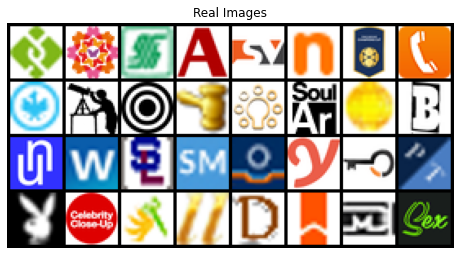

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])
dataset = dset.ImageFolder(data_dir, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:32], padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
class Generator(nn.Module):
   def __init__(self, ngpu):
     super(Generator, self).__init__()
     self.ngpu = ngpu
     self.main = nn.Sequential(
         nn.ConvTranspose2d(noise_size, ngf*4, 4, 1, 0, bias=False),
         nn.BatchNorm2d(ngf*4),
         nn.ReLU(True),
         nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
         nn.BatchNorm2d(ngf*2),
         nn.ReLU(True),
         nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
         nn.BatchNorm2d(ngf),
         nn.ReLU(True),
         nn.ConvTranspose2d(ngf, num_channels, 4, 2, 1, bias=False),
         nn.Tanh()
     )
   def forward(self, input):
        return self.main(input)     

In [ ]:
netG = Generator(ngpu).to(device)
netG.apply(weights_init)
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(50, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)


In [ ]:
class Discriminator(nn.Module):
  def __init__(self, ngpu):
    super(Discriminator, self).__init__()
    self.ngpu = ngpu
    self.main = nn.Sequential(
        nn.Conv2d(num_channels, ndf, 4, 2, 1, bias=False),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ndf * 2),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ndf * 4),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
        nn.Sigmoid()
    )

  def forward(self, input):
      return self.main(input)

In [ ]:
netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): Sigmoid()
  )
)


In [ ]:
criterion = nn.BCELoss()

noise = torch.randn(batch_size, noise_size, 1, 1, device=device)


lr = 0.0005

optimiserG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))
optimiserD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))

In [ ]:
image_list = []
Dlosses = []
Glosses = []

num_epochs = 300

for epoch in range(num_epochs):
  for i, data in enumerate(dataloader, 0):

    real_batch = data[0].to(device)
    bsize = real_batch.size(0)
    real_label = torch.ones((bsize,), device=device)
    fake_label = torch.zeros((bsize,), device=device) 

    netD.zero_grad()       
    label = real_label
    output = netD(real_batch).view(-1)
    real_Dloss = criterion(output, label)
    real_Dloss.backward()

    noise = torch.randn(bsize, noise_size, 1, 1).to(device)
    fake_batch = netG(noise)
    label = fake_label
    output = netD(fake_batch.detach()).view(-1) 
    fake_Dloss = criterion(output, label)
    fake_Dloss.backward()
    total_Dloss = real_Dloss + fake_Dloss
    optimiserD.step()

    netG.zero_grad()
    label = real_label
    output = netD(fake_batch).view(-1)
    Gloss = criterion(output, label)
    Gloss.backward()
    optimiserG.step()

    if  (i % 50 == 0):
      Glosses.append(Gloss.item())
      Dlosses.append(total_Dloss.item())
      if (epoch % 10 == 0):
        print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
              % (epoch, num_epochs, i, len(dataloader), total_Dloss.item(), Gloss.item()))

    if (epoch == num_epochs-1):
      with torch.no_grad():
          fake_batch = netG(noise).detach().cpu()
          image_list.append(vutils.make_grid(fake_batch, padding=2, normalize=True))   
    

[0/300][0/156]	Loss_D: 1.5999	Loss_G: 1.9643
[0/300][50/156]	Loss_D: 0.8234	Loss_G: 2.4275
[0/300][100/156]	Loss_D: 0.7164	Loss_G: 2.2078
[0/300][150/156]	Loss_D: 0.5109	Loss_G: 3.8196
[10/300][0/156]	Loss_D: 1.0086	Loss_G: 2.3594
[10/300][50/156]	Loss_D: 1.2755	Loss_G: 0.7217
[10/300][100/156]	Loss_D: 1.2804	Loss_G: 1.4107
[10/300][150/156]	Loss_D: 0.8838	Loss_G: 1.8190
[20/300][0/156]	Loss_D: 0.3301	Loss_G: 3.4567
[20/300][50/156]	Loss_D: 0.7430	Loss_G: 4.2411
[20/300][100/156]	Loss_D: 0.8299	Loss_G: 1.0039
[20/300][150/156]	Loss_D: 0.5931	Loss_G: 3.6391
[30/300][0/156]	Loss_D: 0.4144	Loss_G: 2.5567
[30/300][50/156]	Loss_D: 0.2570	Loss_G: 3.2909
[30/300][100/156]	Loss_D: 0.5124	Loss_G: 2.7590
[30/300][150/156]	Loss_D: 0.5517	Loss_G: 1.9763
[40/300][0/156]	Loss_D: 0.3045	Loss_G: 3.7348
[40/300][50/156]	Loss_D: 0.3047	Loss_G: 4.3721
[40/300][100/156]	Loss_D: 0.1330	Loss_G: 3.5708
[40/300][150/156]	Loss_D: 0.3449	Loss_G: 2.1124
[50/300][0/156]	Loss_D: 0.1308	Loss_G: 4.3187
[50/300][50/1

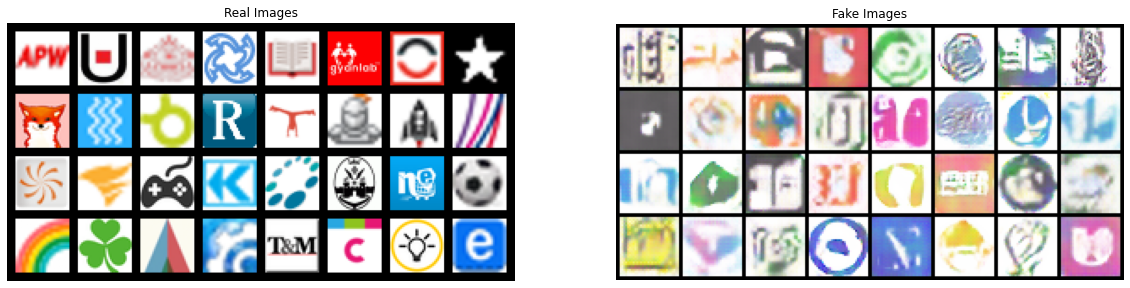

In [ ]:
real_examples = next(iter(dataloader))

plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_examples[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(image_list[-1],(1,2,0)))
plt.show()

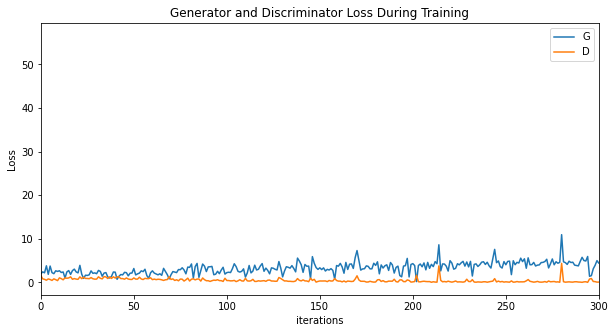

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(Glosses,label="G")
plt.plot(Dlosses,label="D")
plt.xlabel("iterations")
plt.xlim((0,300))
plt.ylabel("Loss")
plt.legend()
plt.show()